In [1]:
import gym
import cv2
from gym import error, spaces
from gym.utils import seeding

import numpy as np
import matplotlib.pyplot as plt
 
from pyrep.pyrep import PyRep
from ArmPSM_model import ArmPSM
from ArmECM_model import ArmECM

If error found, put 'pyglet>=1.4.0,<=1.5.0'in install_requires in the setup.py file of gym

In [2]:
class ECMEnv(gym.GoalEnv):
    def __init__(self, psm_num, n_actions, n_states, n_goals, n_substeps, camera_enabled, scene_path):
        
        self.viewer = None
        
        self.pr = PyRep()
        self.pr.launch(scene_path)
        
        self.psm_num = psm_num
        self.psm = ArmPSM(self.pr, self.psm_num)
        self.ecm = ArmECM(self.pr)
        
        self.n_substeps = n_substeps
        
        self.sim_timestep = 0.1
        
        self.camera_enabled = camera_enabled
        if self.camera_enabled:
            self.metadata = {'render.modes': ['matplotlib', 'rgb', 'human']}
            self.camera = camera(self.pr, rgb = True)
        else:
            self.metadata = {'render.modes': ['human']}
            
        self.seed()
        self._env_setup()
        self.done = False
        
        self.action_space = spaces.Box(-1., 1., shape=(n_actions,), dtype='float32')
        self.observation_space = spaces.Dict(dict(
			desired_goal=spaces.Box(-np.inf, np.inf, shape=(n_goals,), dtype='float32'),
			achieved_goal=spaces.Box(-np.inf, np.inf, shape=(n_goals,), dtype='float32'),
			observation=spaces.Box(-np.inf, np.inf, shape=(n_states,), dtype='float32'),
			))
        self.pr.start()
    
    def __del__(self):
        self.close()
        
    def dt(self):
        return self.sim_timestep * self.n_substeps
    
    def seed(self, seed = None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        if not self.done:
            action = np.clip(action, self.action_space.low, self.action_space.high)
            self._set_action(action)

            self._simulator_step()
            self._step_callback()
        
        obs = self._get_obs()
        
        self.done = False
        reward = 0
        info = {}
        
        return obs, reward, done, info
    
    def get_centroid(self):
        left_image, right_image = self.ecm.getStereoImagePairs()
        left_image = cv2.cvtColor(left_image, cv2.COLOR_RGB2HSV)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_RGB2HSV)
        
        h, s, v = cv2.split(left_image)
        ret, thresh_img = cv2.threshold(v,  127, 255, cv2.THRESH_BINARY)
        M = cv2.moments(thresh_img)
        if not M["m00"]:
            c_x = M["m10"]
            c_y = M["m01"]
        else:
            c_x = int(M["m10"]/M["m00"])
            c_y = int(M["m01"]/M["m00"])
        return [c_x, c_y]
        
    def close(self):
        if self.viewer is not None:
            plt.close(self.viewer.number)
            self.viewer = None
        self.pr.stop()
        self.pr.shutdown()
    
    def _simulator_step(self):
        for i in range(0, self.n_substeps):
            self.pr.step()

    def _reset_sim(self):
        """Resets the simulation and random initialization
        """
        return True

    def _get_obs(self):
        """Returns the observation.
        """
        obs = {'observation' : np.append(np.r_[self.psm1.getPoseAtEE()] - self.ecm.getCurrentPose(), 
                                         self.ecm.getJointAngles()),
              'achieved_goal': np.array([0., 0., 0.]),
              'desired_goal' : np.array([0., 0., 0.])}
        return obs

    def _set_action(self, action):
        """Applies the given action to the simulation.
        """
        obs = self._get_obs()
        self.ecm.setJointAngles(obs[-4:] + action)

    def _is_success(self):
        """Indicates whether or not the needle is passed optimally.
        """
        raise NotImplementedError()

    def _interaction_reward(self, achieved_goal, goal): 
        """Returns the reward based on the interaction result in the simulator
        """
        raise NotImplementedError()

    def _env_setup(self):
        
        self.psm.setJointAngles(np.array([0.,np.radians(-50.0), 0.08, 0., 0., 0.]), np.radians(20.0))
        self.psm.setDynamicsMode(1)
        self.psm.setIkMode(0)
        self.pr.step()
        
    def _viewer_setup(self):
        """Initial configuration of the viewer. Can be used to set the camera position,
        for example.
        """
        pass

    def _render_callback(self):
        """A custom callback that is called before rendering. Can be used
        to implement custom visualizations.
        """
        pass

    def _step_callback(self):
        """A custom callback that is called after stepping the simulation. Can be used
        to enforce additional constraints on the simulation state.
        """
        pass


In [3]:
obj = ECMEnv(1, 6, 10, 2, 100, False, '/home/arclab-flo/Desktop/Bose/CoppeliaSim_Edu_V4_0_0_Ubuntu18_04/scenes/single_arm_one_marker (copy).ttt')

In [4]:
import time

In [5]:
ecm_joint1_angles = np.arange(-75., -30., 5.)
for j1 in ecm_joint1_angles:
    jointAngles = obj.ecm.getJointAngles()
    jointAngles[0] = np.radians(j1)
    #jointAngles[2] = j1
    obj.ecm.setJointAngles(jointAngles)
    obj.pr.step()
    
    print (obj.get_centroid())
    time.sleep(1.0)

[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]


V-rep get tool in the camera frame, set position (pick and save proper initialization)
ECM
Joint 1: (-75, 45) @ 0
Joint 21: @ 15
Joint 22: @ -15
Joint 23: @ 15
Joint 2: (-45, 65) @ 15
Joint 3: (0, 0.235 m) @ 0
Joint 4: (-90, 90) @ 0

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

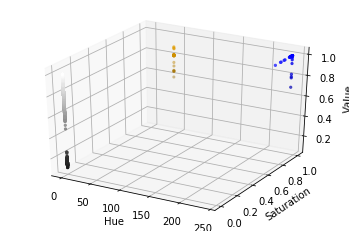

In [33]:
li, ri = obj.ecm.getStereoImagePairs()
hsv_image = cv2.cvtColor(li, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection = "3d")
pixel_colors = li.reshape((li.shape[0] * li.shape[1], 3))
norm = colors.Normalize(vmin = -1., vmax = 1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors = pixel_colors, marker = ".")
axis.set_xlabel('Hue')
axis.set_ylabel('Saturation')
axis.set_zlabel('Value')
plt.show()

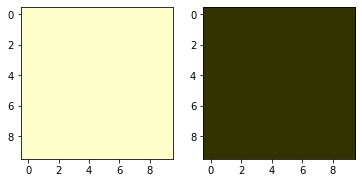

In [47]:
lower_limit = (51, 51, 0)
higher_limit = (255, 255, 204)
b_square = np.full((10, 10, 3), np.array(lower_limit), dtype = np.uint8)/255.0
db_square = np.full((10, 10, 3), np.array(higher_limit), dtype = np.uint8)/255.0
plt.subplot(1, 2, 1)
plt.imshow(db_square)
plt.subplot(1, 2, 2)
plt.imshow(b_square)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


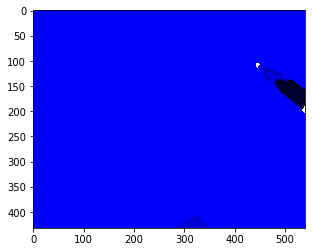

In [48]:
plt.imshow(hsv_image)

In [50]:
mask = cv2.inRange(hsv_image, lower_limit, higher_limit)
#To impose the mask on the original image
result = cv2.bitwise_and(li, li, mask = mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


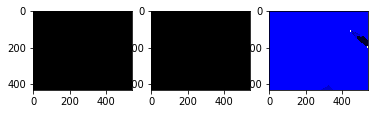

In [51]:
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap = "gray")
plt.subplot(1, 3, 2)
plt.imshow(result)
plt.subplot(1, 3, 3)
plt.imshow(hsv_image)
plt.show()

In [37]:
np.count_nonzero(result)

0

In [8]:
obj.close()